## Download data from kaggle and move to s3

In [ ]:
"""
!pip install kaggle
!kaggle datasets download -d robinreni/signature-verification-dataset
!unzip -q signature-verification-dataset.zip
!aws s3 cp ./sign_data/ s3://udacity-mle-capstone/ --recursive
"""

In [2]:
!pip install scikit-image

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import img_as_ubyte
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage import filters, transform

from typing import Tuple

## look at class imbalance in train/test sets

In [4]:
train_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/train_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
train_df['img_path_real'] = train_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/train/{x}')
train_df['img_path_forged'] = train_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/train/{x}')

test_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/test_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
test_df['img_path_real'] = test_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')
test_df['img_path_forged'] = test_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')

In [5]:
print('train set imbalance')
print(train_df['label'].value_counts())
print(train_df['label'].value_counts(normalize=True))

train set imbalance
0    12602
1    10603
Name: label, dtype: int64
0    0.543073
1    0.456927
Name: label, dtype: float64


In [6]:
print('test set imbalance')
print(test_df['label'].value_counts())
print(test_df['label'].value_counts(normalize=True))

test set imbalance
1    2975
0    2772
Name: label, dtype: int64
1    0.517661
0    0.482339
Name: label, dtype: float64


## look at pairs of real and forged images

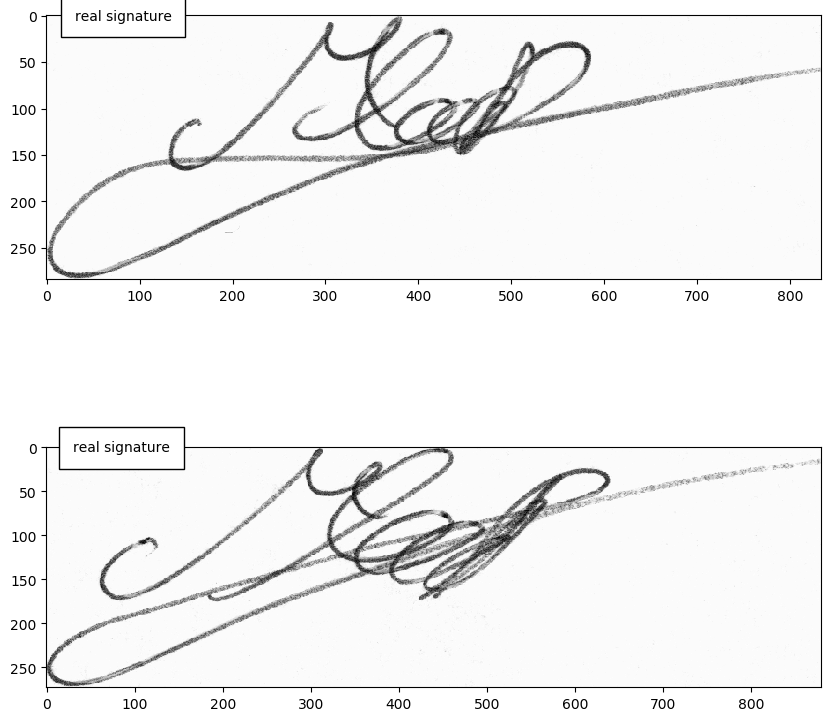

In [33]:
_df = train_df[train_df['label']==0].sample(1)
img1 = img_as_ubyte(imread(_df['img_path_real'].iloc[0], as_gray=True))
img2 = img_as_ubyte(imread(_df['img_path_forged'].iloc[0], as_gray=True))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r', label='real')
ax1.imshow(img2, cmap='binary_r')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()

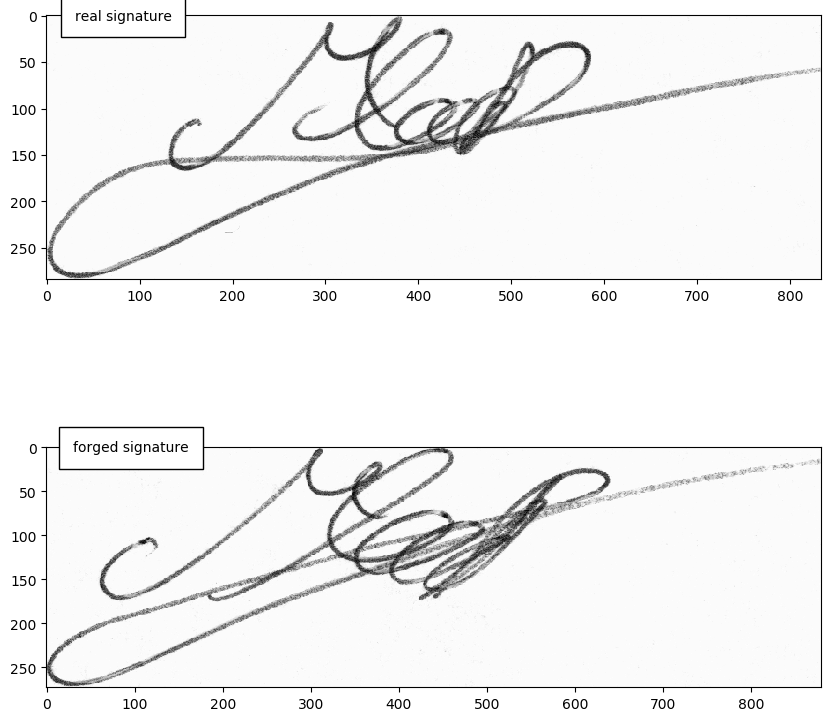

In [34]:
_df = train_df[train_df['label']==1].sample(1)
img3 = img_as_ubyte(imread(_df['img_path_real'].iloc[0], as_gray=True))
img4 = img_as_ubyte(imread(_df['img_path_forged'].iloc[0], as_gray=True))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r')
ax1.imshow(img2, cmap='binary_r')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10})
plt.show()

## apply preprocessing to images

In [58]:
def load_image(fname):
    return img_as_ubyte(imread(fname, as_gray=True))

def preprocess_image(image, radius=2, resize_dims = (50,70)):
    image = image.astype(np.uint8)
    blurred_image = filters.gaussian(image, radius, preserve_range=True)
    threshold = filters.threshold_otsu(blurred_image)
    binarized_image = blurred_image > threshold
    image_background_removed = np.where(binarized_image==False, 255-image, 0)
    image_background_removed = transform.resize(image_background_removed, resize_dims, mode='constant', anti_aliasing=True, preserve_range=True)
    image_background_removed = image_background_removed /255.0
    image_background_removed = np.pad(image_background_removed, (20, 20), 'constant', constant_values=(0,0))
    return image_background_removed

In [59]:
%time
_df = train_df[train_df['label']==0].sample(1)
img1 = preprocess_image(load_image(_df['img_path_real'].iloc[0]))
img2 = preprocess_image(load_image(_df['img_path_forged'].iloc[0]))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


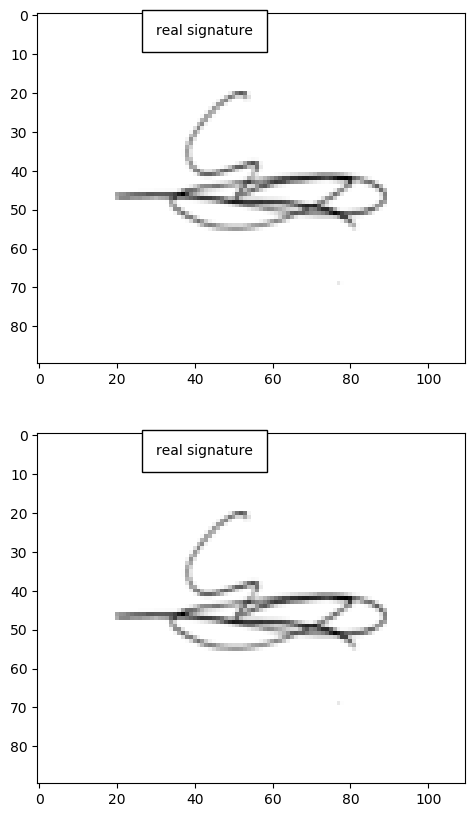

In [60]:
_df = train_df[train_df['label']==0].sample(1)
img1 = preprocess_image(load_image(_df['img_path_real'].iloc[0]))
img2 = preprocess_image(load_image(_df['img_path_real'].iloc[0]))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary', label='real')
ax1.imshow(img2, cmap='binary')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()

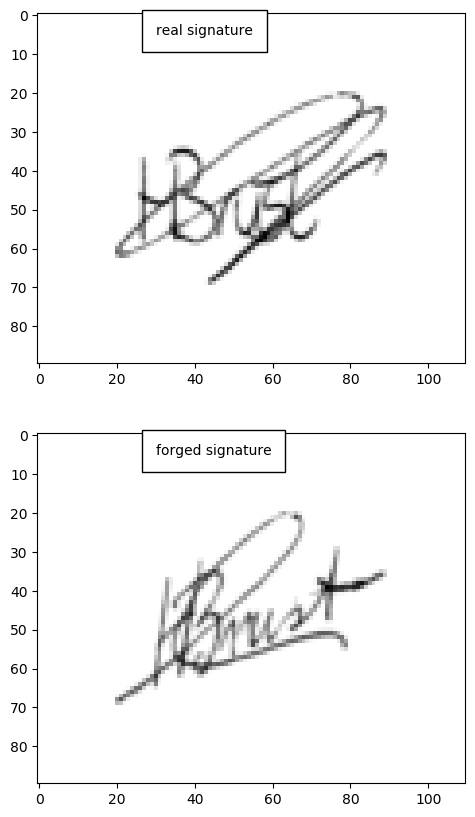

In [61]:
_df = train_df[train_df['label']==1].sample(1)
img3 = preprocess_image(load_image(_df['img_path_real'].iloc[0]))
img4 = preprocess_image(load_image(_df['img_path_forged'].iloc[0]))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img3, cmap='binary', label='real')
ax1.imshow(img4, cmap='binary')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()